In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from collections import Counter

# Load library
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# download the set of stop words the first time
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import re

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cesleemontgomery/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/cesleemontgomery/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2.1A - EDA - User Interest Model (Wikipedia.org data)

In [31]:
wikiPagePathsDF = pd.read_csv('../../data/raw/articles_wikipedia/academic_outline_wikipedia_pages.csv')

### 1. Summary Statistics & Initial Impressions

#### 1.1 Size

In [5]:
wikiPagePathsDF.shape

(985, 7)

985 is quite a few academic interests to make available to users to choose from.  My suspision is that only up to level topic_3 is necessary, but for computer science more levels might be useful.

#### 1.2 Interests Count by Category

In [6]:
wikiPagePathsDF.groupby('category_h2_1').nunique()

,category_h2_1,sub_category_h3_2,topic_3,subtopic_4,subtopic_5,page_href,page_text
category_h2_1,,,,,,,
Applied Sciences,1,3,59,48,0,111,108
Formal Sciences,1,3,36,129,0,165,162
Humanities,1,6,52,119,44,222,220
Natural Sciences,1,5,111,47,0,164,162
Social sciences,1,7,263,34,0,296,283


- There are few sub-categories but many topics.  This imbalance could mean that most of the granularity is hidden away and people will only make surface choices and users who go deeper may then be overwhelmed by the topics available.  Not sure how to address this, some topics could be promoted if they're highly related.
- Its surprising that there would be fewer page_texts than page_href's as they should be one to one.  Will look into this further with textual analysis below.

##### 1.2.1 Total Interests Count

In [7]:
wikiPagePathsDF.groupby('category_h2_1')['category_h2_1', 'sub_category_h3_2', 'topic_3', 'subtopic_4', 'subtopic_5'].nunique().sum(1)

category_h2_1
Applied Sciences    111
Formal Sciences     169
Humanities          222
Natural Sciences    164
Social sciences     305
dtype: int64

The total interest counts don't perfectly align with the num. of unique page_hrefs in the case of Formal Sciences, and social sciences.

In [8]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(wikiPagePathsDF[wikiPagePathsDF['category_h2_1'] == 'Formal Sciences'])

,category_h2_1,sub_category_h3_2,topic_3,subtopic_4,subtopic_5,page_href,page_text
701,Formal Sciences,NaN,NaN,NaN,NaN,"['/wiki/Formal_science', '/wiki/Outline_of_for...",Formal sciences are formal language discipline...
702,Formal Sciences,Computer Science,NaN,NaN,NaN,"['/wiki/Computer_science', '/wiki/Outline_of_c...",Computer science (sometimes called computation...
703,Formal Sciences,Computer Science,Logic in computer science,NaN,NaN,/wiki/Logic_in_computer_science,Logic in computer science covers the overlap b...
704,Formal Sciences,Computer Science,Logic in computer science,Formal methods (Formal verification),NaN,"['/wiki/Formal_methods', '/wiki/Formal_verific...","In computer science, specifically software eng..."
705,Formal Sciences,Computer Science,Logic in computer science,Logic programming,NaN,/wiki/Logic_programming,Logic programming is a type of programming par...
706,Formal Sciences,Computer Science,Logic in computer science,Multi-valued logic,NaN,/wiki/Multi-valued_logic,"In logic, a many-valued logic (also multi- or ..."
707,Formal Sciences,Computer Science,Logic in computer science,Programming language semantics,NaN,/wiki/Formal_semantics_of_programming_languages,"In programming language theory, semantics is t..."
708,Formal Sciences,Computer Science,Logic in computer science,Type theory,NaN,/wiki/Type_theory,"In mathematics, logic, and computer science, a..."
709,Formal Sciences,Computer Science,Algorithms,NaN,NaN,/wiki/Algorithm,"In mathematics and computer science, an algori..."
710,Formal Sciences,Computer Science,Algorithms,Computational geometry,NaN,/wiki/Computational_geometry,Computational geometry is a branch of computer...


Statistics is duplicated because its a subfield of math and its own field.  This would explain more topics than hrefs.  I can address the missing statistics subfields later.  I don't think this warrants more time investment.

In [9]:
tempdf = wikiPagePathsDF[wikiPagePathsDF['category_h2_1'] == 'Formal Sciences']
tempdf[tempdf.duplicated(['page_href'])]

,category_h2_1,sub_category_h3_2,topic_3,subtopic_4,subtopic_5,page_href,page_text
770,Formal Sciences,Computer Science,Programming languages,Type theory,NaN,/wiki/Type_theory,"In mathematics, logic, and computer science, a..."
773,Formal Sciences,Computer Science,Software engineering,Formal methods (Formal verification),NaN,"['/wiki/Formal_methods', '/wiki/Formal_verific...","In computer science, specifically software eng..."
840,Formal Sciences,Mathematics,Cryptography,NaN,NaN,/wiki/Cryptography,Cryptography or cryptology (from Ancient Greek...
846,Formal Sciences,Mathematics,Information theory,NaN,NaN,/wiki/Information_theory,"Information theory studies the quantification,..."
852,Formal Sciences,Mathematics,Numerical analysis,NaN,NaN,/wiki/Numerical_analysis,Numerical analysis is the study of algorithms ...
871,Formal Sciences,Mathematics,Theory of computation,NaN,NaN,/wiki/Theory_of_computation,In theoretical computer science and mathematic...
872,Formal Sciences,Mathematics,Theory of computation,Computational complexity theory,NaN,/wiki/Computational_complexity_theory,Computational complexity theory focuses on cla...
873,Formal Sciences,Statistics,NaN,NaN,NaN,"['/wiki/Statistics', '/wiki/Outline_of_statist...",Statistics is a branch of mathematics working ...


In [10]:
tempdf[tempdf.page_href == '/wiki/Type_theory']

,category_h2_1,sub_category_h3_2,topic_3,subtopic_4,subtopic_5,page_href,page_text
708,Formal Sciences,Computer Science,Logic in computer science,Type theory,NaN,/wiki/Type_theory,"In mathematics, logic, and computer science, a..."
770,Formal Sciences,Computer Science,Programming languages,Type theory,NaN,/wiki/Type_theory,"In mathematics, logic, and computer science, a..."


After manually checking [Outline @ wikipedia.org](https://en.wikipedia.org/wiki/Outline_of_academic_disciplines#Computer_Science) Type Theory indeed shows up under two topics.  For now this will suffice as an explanation for why there are duplicates.

#### 1.3 Visual Inspection


In [11]:
wikiPagePathsDF.tail()

,category_h2_1,sub_category_h3_2,topic_3,subtopic_4,subtopic_5,page_href,page_text
980,Applied Sciences,Medicine and health,Surgery,Traumatology,NaN,/wiki/Traumatology,"In medicine, traumatology (from Greek trauma, ..."
981,Applied Sciences,Medicine and health,Traditional medicine,NaN,NaN,/wiki/Traditional_medicine,Traditional medicine (also known as indigenous...
982,Applied Sciences,Medicine and health,Urology,NaN,NaN,/wiki/Urology,"Urology (from Greek οὖρον ouron ""urine"" and -λ..."
983,Applied Sciences,Medicine and health,Urology,Andrology,NaN,/wiki/Andrology,"Andrology (from Ancient Greek: ἀνήρ, anēr, gen..."
984,Applied Sciences,Medicine and health,Veterinary medicine,NaN,NaN,/wiki/Veterinary_medicine,Veterinary medicine is the branch of medicine ...


Some categories I expect, will not be useful.  Examples above of surgery, etc are a good example.  I expect these to fall out as they have low similarity to courses.

### 2. Text Analytics

#### 2.1 Avg. Text Length and Std Deviation

In [12]:
(wikiPagePathsDF.groupby('category_h2_1')['page_text']
                    .apply(lambda x: np.mean(x.str.len()))
                    .reset_index(name='mean_len_page_text'))

,category_h2_1,mean_len_page_text
0,Applied Sciences,23805.837838
1,Formal Sciences,32011.907514
2,Humanities,35011.589286
3,Natural Sciences,19008.186747
4,Social sciences,22935.392857


In [13]:
(wikiPagePathsDF.groupby('category_h2_1')['page_text']
                    .apply(lambda x: np.nanstd(x.str.len()))
                    .reset_index(name='std_len_page_text'))

,category_h2_1,std_len_page_text
0,Applied Sciences,22749.536171
1,Formal Sciences,27076.463128
2,Humanities,32754.914091
3,Natural Sciences,19827.899650
4,Social sciences,20426.536423


The standard deviations strike me as being quite high.  Let's look at this in more detail.

#### 2.2 Visually Inspecting Distribution of Article Lengths

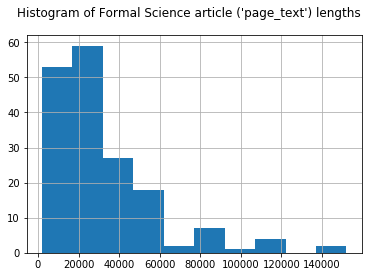

In [14]:
wikiPagePathsDF[wikiPagePathsDF['category_h2_1'] == 'Formal Sciences'].page_text.str.len().hist()
plt.suptitle("Histogram of Formal Science article ('page_text') lengths");

As expected because most texts are similar lengths, but a few will be very long, the article lengths follow a **Log-Normal Distribution.**

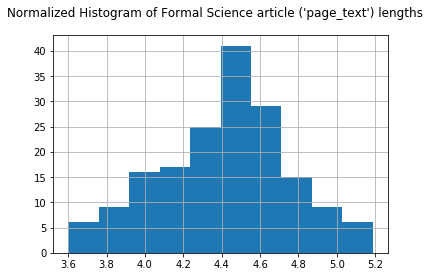

In [15]:
np.log10(wikiPagePathsDF[wikiPagePathsDF['category_h2_1'] == 'Formal Sciences'].page_text.str.len() + 2000).hist()
plt.suptitle("Normalized Histogram of Formal Science article ('page_text') lengths");

Through a log transformation, we can confirm that it looks like a gaussian, indicating we can treat it as a gaussian after transforming.

### 3. Text Pre-Processing

#### 3.1 Lower, split/strip whitespace chars., remove stop words

In [16]:
tempdf = wikiPagePathsDF[wikiPagePathsDF['category_h2_1'] == 'Formal Sciences'].page_text.values

#lowercase,remove punctuation and non-alpha, split whitespace
templist = ''.join(tempdf).lower()
templist = re.sub("[^a-zA-Z\s]+", "", templist).split()
templist[0:10]

['formal',
 'sciences',
 'are',
 'formal',
 'language',
 'disciplines',
 'concerned',
 'with',
 'formal',
 'systems']

In [17]:
# Load stop words, lemmatizer
stop_words = stopwords.words('english')
lemma = nltk.wordnet.WordNetLemmatizer()

# Show stop words
# stop_words[:100]

# Remove stop words, lowercase, lemmatize
tempdict = Counter([lemma.lemmatize(word.lower()) for word in templist if word not in stop_words])

In [18]:
print('Most Common Words in Formal Sciences articles: \n')
for i in tempdict.most_common(20): print(i)

Most Common Words in Formal Sciences articles: 

('theory', 3789)
('x', 3239)
('system', 3153)
('displaystyle', 3113)
('computer', 2343)
('set', 2334)
('number', 2052)
('problem', 2019)
('one', 1977)
('also', 1916)
('space', 1867)
('field', 1820)
('used', 1761)
('function', 1760)
('data', 1748)
('example', 1644)
('n', 1630)
('science', 1436)
('model', 1414)
('method', 1328)


In [19]:
# Building function for easy comparison
def get_counter_from_list(templist):

    #lowercase,remove punctuation and non-alpha, split whitespace
    templist = ''.join(templist).lower()
    templist = re.sub("[^a-zA-Z\s]+", "", templist).split()

    # Load stop words, lemmatizer
    stop_words = stopwords.words('english')
    lemma = nltk.wordnet.WordNetLemmatizer()

    # Remove stop words, lowercase, lemmatize
    counter = Counter([lemma.lemmatize(word.lower()) for word in templist if word not in stop_words])
    return counter

In [20]:
tempdf = wikiPagePathsDF[wikiPagePathsDF['category_h2_1'] == 'Humanities'].page_text.values

print('Most Common Words in Humanities articles: \n')
for i in get_counter_from_list(tempdf).most_common(20): print(i)

Most Common Words in Humanities articles: 

('law', 4038)
('century', 2998)
('also', 2977)
('music', 2969)
('history', 2908)
('philosophy', 2831)
('language', 2535)
('one', 2441)
('state', 2407)
('th', 2334)
('new', 2250)
('theory', 2181)
('first', 2124)
('work', 2068)
('world', 1969)
('many', 1917)
('form', 1882)
('study', 1878)
('system', 1690)
('time', 1647)


For fun, let's go more granular to see if categories are more believable.

In [32]:
tempdf = wikiPagePathsDF[wikiPagePathsDF['subtopic_5'] == 'Jazz studies'].page_text.values

print("Most Common Words in 'Jazz Studies' articles: \n")
for i in get_counter_from_list(tempdf).most_common(20): print(i)

Most Common Words in 'Jazz Studies' articles: 

('jazz', 444)
('music', 142)
('musician', 82)
('new', 80)
('blue', 73)
('band', 71)
('style', 64)
('rhythm', 49)
('african', 45)
('form', 42)
('musical', 42)
('bebop', 39)
('orleans', 38)
('early', 38)
('first', 36)
('free', 35)
('many', 34)
('swing', 33)
('improvisation', 33)
('fusion', 33)


yep, more believable!

### 3.2 Investigating quality of keywords and opportunities for improvement
Let's dig deeper into the category of computer science to see how much work needs to be done to refine keywords.

In [33]:
name = 'Computer Science'
level = 'sub_category_h3_2'
tempdf = wikiPagePathsDF[wikiPagePathsDF[level] == name].page_text.values

print("Most Common Words in {} articles: \n".format(name))
for i in get_counter_from_list(tempdf).most_common(20): print(i)

Most Common Words in Computer Science articles: 

('system', 2151)
('computer', 2031)
('data', 1245)
('language', 1130)
('used', 1049)
('science', 981)
('information', 922)
('also', 919)
('network', 918)
('problem', 913)
('theory', 894)
('algorithm', 840)
('one', 832)
('use', 813)
('model', 778)
('may', 772)
('computing', 762)
('program', 711)
('machine', 711)
('type', 702)


In [34]:
name = 'Software engineering'
level = 'topic_3'
tempdf = wikiPagePathsDF[wikiPagePathsDF[level] == name].page_text.values

print("Most Common Words in {} articles: \n".format(name))
for i in get_counter_from_list(tempdf).most_common(20): print(i)

Most Common Words in Software engineering articles: 

('software', 159)
('engineering', 91)
('formal', 78)
('system', 77)
('verification', 46)
('specification', 43)
('method', 42)
('program', 35)
('engineer', 32)
('development', 31)
('model', 31)
('language', 29)
('used', 28)
('computer', 28)
('professional', 24)
('approach', 23)
('also', 22)
('process', 22)
('proof', 22)
('may', 19)


In [37]:
name = 'Artificial intelligence'
level = 'topic_3'
tempdf = wikiPagePathsDF[wikiPagePathsDF[level] == name].page_text.values

print("Most Common Words in {} articles: \n".format(name))
for i in get_counter_from_list(tempdf).most_common(20): print(i)

Most Common Words in Artificial intelligence articles: 

('robot', 488)
('ai', 276)
('human', 241)
('intelligence', 240)
('system', 230)
('artificial', 193)
('robotics', 174)
('machine', 152)
('computer', 135)
('science', 108)
('used', 103)
('cognitive', 101)
('also', 96)
('learning', 93)
('problem', 93)
('research', 93)
('knowledge', 92)
('many', 89)
('use', 79)
('example', 78)


In [38]:
name = 'Cognitive science'
level = 'subtopic_4'
tempdf = wikiPagePathsDF[wikiPagePathsDF[level] == name].page_text.values

print("Most Common Words in {} articles: \n".format(name))
for i in get_counter_from_list(tempdf).most_common(20): print(i)

Most Common Words in Cognitive science articles: 

('cognitive', 79)
('science', 50)
('study', 27)
('brain', 26)
('human', 23)
('process', 22)
('field', 20)
('model', 20)
('language', 19)
('mind', 18)
('intelligence', 18)
('memory', 18)
('system', 15)
('information', 15)
('computer', 15)
('cognition', 13)
('behavior', 13)
('psychology', 13)
('one', 13)
('approach', 13)


Let's also calculate TF-IDF for comparison, suffering from too many common non-topical words. (use/used, one, etc)

### 4. Takeaways

- Data looks good given quality checks.
    - Import looks correct (no odd/missing hrefs, texts, or labels)
    - Text lengths distribtion looks approximately normal after log transformation.
    - After pre-processing, top words by category looks believable.
- Few sub-categories, many topics - will see what drops out after TF-IDF weighting.  Should evaluate user experience before adjusting this manually somehow.
- Some test-processing done, will bootstrap from this in model building.

### 5. Future Directions

#### 5.0 Bug Fixes
    - Missing subcategories for Statistics and possibly others (see above).
#### 5.1 More Pre-Processing
    - Remove or digest references?
    - Split text into "slots" of type of data?
    - Add stupid common words manually to blacklist
    
#### 5.2 Tooling
    - Create input:interests, output common keywords widget